<a href="https://colab.research.google.com/github/sebastianmunozvasq/Portfolio-SMV/blob/Boundary-value-problems/Cooling_of_a_fluid_by_natural_convection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cooling of a fluid by natural convection



### Preparation: Import modules

In [ ]:
# Data visualization and plots
import matplotlib.pyplot as plt

# Numerical computation
import numpy as np


### Topic 1: Computational implementation of the system of equations

The problem at the boundary values we wish to solve is:

ODE:

$$\alpha \frac{d^2T}{dx^2}=v_0 \frac{dT}{dx}+\frac{4h}{\rho \hat{c}_p d_i}(T-T_\infty)$$

BC1: At the inlet of the pipe, the fluid temperature is known and equal to $T_{in}$.

$$T(x=0) = T_{in}$$

BC2: At the outlet of the pipe, the axial temperature gradient is zero:

$$\frac{dT}{dx}\bigg|_{x=L} = 0$$

Domain: A pipe of length $L$ starting at $x=0$ is considered.

$$0 \leq x \leq L$$


#### 1.1 Define in Python the physical parameters that do not depend on discretization

In [ ]:
# Liquid density
rho = 950 # kg/m^3

# Thermal diffusivity of water evaluated at the average temperature
alpha = 1.16e-7 # m^2/s, liquid copper

# Specific heat
c_p = 3800 # J/kg/K

# Pipe diameter
d_i = 0.0254 * 2 # m

# Temperature at the pipe inlet
T_in = 90 + 273.15 # K

# Ambient temperature
T_air = 18 + 273 # K

# Natural convection heat transfer coefficient
h = 10 # W/m^2#K

# Velocity
v_0 = 0.01 # m/s

# Pipe length
L = 100 # m


#### 1.2: PVC Discretization

The discretized form of the problem at the boundary values is:

System of equations derived from the discretized ODE, valid for interior nodes $ 2 \leq i \leq N-1$:

$$\alpha \frac{T_{i-1}-2T_i+T_{i+1}}{\Delta x^2}=v_0 \frac{T_{i+1}-T_{i-1}}{2\Delta x}+\frac{4h}{\rho c_p d_i}(T_i-T_\infty)$$

Which can be rewritten as:

$$  
\left(\frac{\alpha}{\Delta x^2}+\frac{v_0}{2\Delta x}\right)T_{i-1}+\left(-\frac{2\alpha}{\Delta x^2}-\frac{4h}{\rho c_p d_i}\right)T_i+\left(\frac{\alpha}{\Delta x^2}-\frac{v_0}{2\Delta x}\right)T_{i+1}=-\left(\frac{4hT_\infty}{\rho c_p d_i}\right)$$

Discretized BC1, valid for $i=1$:

$$T_1 = T_{in}$$

Discretized BC2, valid for $i=N$:

$$T_{N-2} - 4 T_{N-1} + 3 T_N = 0 $$


#### 1.3 Define computational nodes

The dimensions of the matrix associated with the PVC will be defined by the number of nodes in which we decide to discretize the space. For this example, we will consider a 100 meter long pipe and use $n_z = 101$ nodes.

In [ ]:
# Number of nodes
n_x = 101

# Computational grid
x = np.linspace(0, L, n_x)

# Calculate the spacing in a uniform grid
dx = L / (n_x - 1)

# Note that this is equivalent to x[2] - x[1], and thus
# it is associated with the computational grid


#### 1.4 Key step: generate the coefficient matrix for EDO and boundary conditions

In [ ]:
# Generate the coefficient matrix A
A = np.zeros([n_x, n_x])
b = np.zeros([n_x, 1])

# Fill the interior nodes of matrix A and vector b

for i in range(1, n_x-1):

    # Coefficient multiplying T_{i-1}
    A[i, i-1] = alpha/dx**2 + v_0/(2*dx)

    # Coefficient multiplying T_{i}
    A[i, i] = -2*alpha/dx**2 - 4*h/(rho*c_p*d_i)

    # Coefficient multiplying T_{i+1}
    A[i, i+1] = alpha/dx**2 - v_0/(2*dx)

    # Right-hand side vector
    b[i] = -4*h*T_air/(rho*c_p*d_i)

# Boundary condition at z = 0
A[0, 0] = 1
b[0] = T_in

# Boundary condition at z = L
A[-1, -3] = 1
A[-1, -2] = -4
A[-1, -1] = 3
b[-1] = 0


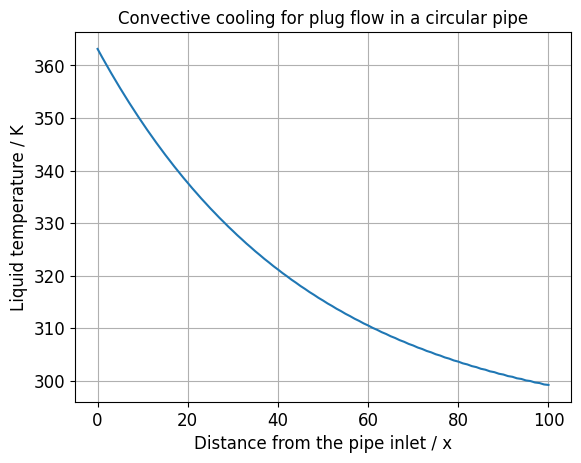

In [ ]:
T = np.linalg.solve(A, b)
plt.figure()
plt.plot(x, T)
plt.xlabel('Distance from the pipe inlet / x', size=12)
plt.ylabel('Liquid temperature / K', size=12)
plt.tick_params(labelsize=12)
plt.title("Convective cooling for plug flow in a circular pipe")
plt.grid()


#### Analytical solution construction (optional)

In [ ]:
# Peclet number
Pe = v_0 * L / alpha

# Dimensionless parameter associated with convective cooling
eta = 4 * h * L**2 / (rho * c_p * d_i * alpha)

# Roots of the characteristic polynomial
lambda_1 = (Pe + np.sqrt(Pe**2 + 4 * eta)) / 2
lambda_2 = (Pe - np.sqrt(Pe**2 + 4 * eta)) / 2

# Dimensionless temperature at the pipe inlet
theta_0 = T_in - T_air

def theta(x):
    c_1 = (-theta_0 * (lambda_2 / lambda_1) * np.exp(lambda_2 - lambda_1) /
          (1 - (lambda_2 / lambda_1) * np.exp(lambda_2 - lambda_1)))

    c_1_crop = (-theta_0 * (lambda_2 / lambda_1) * np.exp(lambda_2 - lambda_1) /
                (1 - (lambda_2 / lambda_1) * np.exp(lambda_2 - lambda_1)))

    c_2 = theta_0 - c_1

    if lambda_1 < 300:
        theta_an = c_1 * np.exp(lambda_1 * x) + c_2 * np.exp(lambda_2 * x)
    else:
        theta_an = c_1_crop * np.exp(lambda_2 - lambda_1 * (1 - x)) + c_2 * np.exp(lambda_2 * x)

    return theta_an

# Define the dimensionless grid
xi_span = np.linspace(0, 1, 100)

# Calculate the dimensionless temperature and convert it to original variables
T_an = theta(xi_span) + T_air

# Convert the dimensionless grid to original variables
x_span = xi_span * L


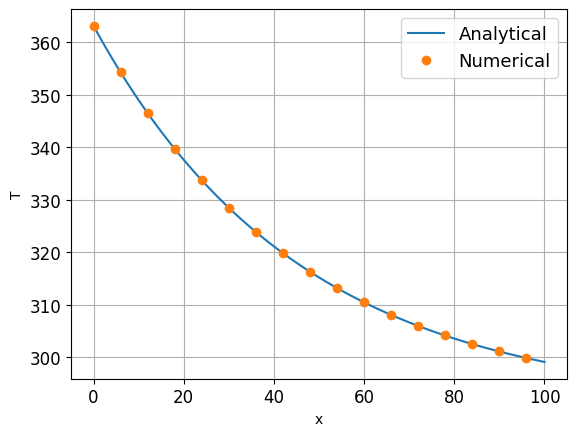

In [ ]:
# Create a new figure
plt.figure()
plt.plot(x_span, T_an, label='Analytical')

# Plot 20 points spaced between 0 and 101:

# Number of points to plot
n_p = 16

# Spacing between points to plot
sp = int(n_x / n_p)

# Extract n_p equally spaced points
# for position and temperature using list comprehension
T_num = np.array([T[i][0] for i in range(0, n_x, sp)])
x_num = np.array([x[i] for i in range(0, n_x, sp)])

# Plot the numerical solution
plt.plot(x_num, T_num, 'o', label='Numerical')
plt.xlabel('x')
plt.ylabel('T')
plt.tick_params(labelsize=12)

# Add grid
plt.grid()
plt.legend(fontsize=13)
plt.show()
